Here we will try to define from scratch micrograd

In [60]:
#pip install graphviz
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # this to be used before defining the grad in the notebook
    #dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    # this to be used after defining the grad
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [81]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

value of f in x0=3 is 20


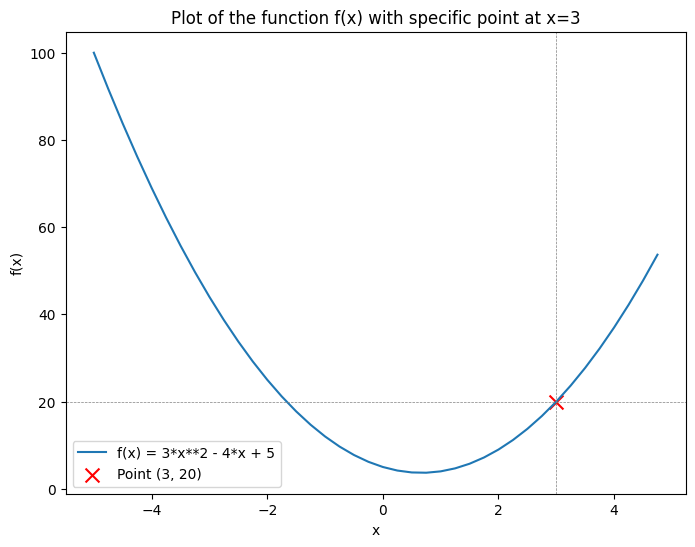

In [7]:
x0 = 3
y0 = f(x0)
print(f"value of f in x0={x0} is {y0}")
xs = np.arange(-5,5,0.25)
ys = f(xs)

plt.figure(figsize=(8, 6))
plt.plot(xs, ys, label='f(x) = 3*x**2 - 4*x + 5')  # Plotting the function
plt.scatter(x0, y0, color='red', marker='x', s=100, label=f'Point ({x0}, {y0})')  # Marking the specific point
# Adding dotted lines
plt.axhline(y=y0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal line
plt.axvline(x=x0, color='gray', linestyle='--', linewidth=0.5)  # Vertical line
# Add labels and legend
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Plot of the function f(x) with specific point at x={3}')
plt.legend()
# Show the plot
plt.show()

No what is the derivative of our funciton $f(x) = 3x^2 - 4x + 5$ ?

So mathematically this is : $$\frac{df(x)}{dx}= f'(x)= 6*x - 4$$
And numerically, this is defined (see wikipedia) : "A function of a real variable $f(x)$ is differentiable at a point a of its domain, if its domain contains an open interval I containing a and the limit L exists:
$$L=\lim_{h\rightarrow 0} = \frac{f(a+h) - f(a)}{h}$$

Example for the value of $x=3$, we have that $f'(3)=14$

In [13]:
x0 = 3.0
h_values = np.logspace(start=0, stop=-7, num=10)
for h in h_values:
    L = (f(x0+h) - f(x0))/h
    print(L) 

17.0
14.500430161159995
14.083476782066324
14.01392476650206
14.002322791046812
14.000387464959914
14.000064632954599
14.000010780775513
14.000001792362957
14.000000305713911


In [14]:
x0 = 2/3
h_values = np.logspace(start=0, stop=-7, num=10)
for h in h_values:
    L = (f(x0+h) - f(x0))/h
    print(L) 

2.999999999999999
0.5004301611600173
0.08347678206620023
0.013924766500807255
0.0023227910477415176
0.0003874648982451067
6.463302707136753e-05
1.0781275548933037e-05
1.7978862859744562e-06
2.9753977059954195e-07


In [15]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [17]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope',(d2-d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


### Data structure for our micrograd

In [2]:
class Value:
    def __init__(self,data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

a = Value(2.0)
b = Value(-3.0)

# If we want to add '+' operator, we need to define this in the class Value otherwise we get an error
a+b


TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [4]:
class Value:
    def __init__(self,data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data)
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
# here now a + b is equivalent to : a.__add__(b)
print(a.__add__(b))
print('a+b = ',a+b)
print('a*b =',a*b)

Value(data=-1.0)
a+b Value(data=-1.0)
a*b Value(data=-6.0)


In [73]:
# Now we need to add connection between the nodes of differencation (adding children)

class Value:
    def __init__(self,data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other))
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other))
        return out

    
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print('d= ',d)
print('d_prev= ',d._prev)


d=  Value(data=4.0)
d_prev=  {Value(data=-6.0), Value(data=10.0)}


In [22]:
for v in d._prev:
    print(v._prev)

set()
{Value(data=2.0), Value(data=-3.0)}


In [146]:
# Now we need to inform of the operation of each step by adding _op 

class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
           self.grad += (1 - t**2) * out.grad  
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    

In [78]:

a = Value(2.0,label='a')
b = Value(-3.0, label='b')
c = Value(10.0,label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
print('d= ',d)
print(f"d._prev : {d._prev} with operation {d._op}")
for v in d._prev:
    print(f"{v._prev} with operation {v._op}")

d=  Value(data=4.0)
d._prev : {Value(data=10.0), Value(data=-6.0)} with operation +
set() with operation 
{Value(data=-3.0), Value(data=2.0)} with operation *


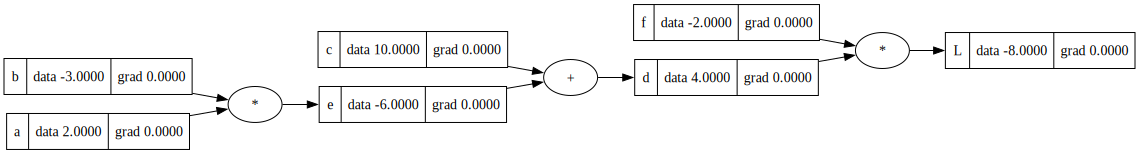

In [61]:
draw_dot(L)

In [67]:
#This could be used each time to check the value for each grad
def local_manual_grad():
    h = 0.00001
    a = Value(2.0,label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0,label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label = 'e'
    d = e + c;  d.label = 'd'
    f = Value(-2.0+h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data 
    print((L2-L1)/h)
local_manual_grad()

4.000000000026205


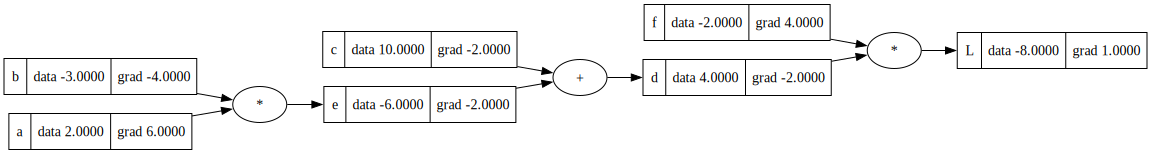

In [69]:
L.grad = 1.0 # dL/dL = 1
f.grad = 4.0 # dL/df = d = 4
d.grad = -2.0 # dL/dd = f = -2
c.grad = -2 # (dL/dc = dL/dd * dd/dc = -2 * 1 = -2)
e.grad = -2 # (dL/de = dL/dd * dd/de = -2 * 1 = -2 )
a.grad =  6 # dL/da = dL/de * de/da = -2 * b = -2 * (-3) = 6
b.grad =  -4 # dL/db = dL/de * de/da = -2 * a = -2 * 2 = -4

draw_dot(L)

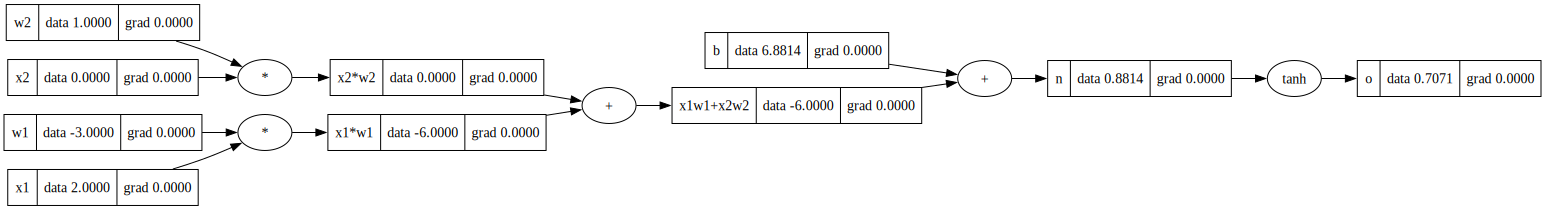

In [93]:
# now we will apply a graph using neuron architecture

#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
out = n.tanh(); out.label = 'o'
draw_dot(out)

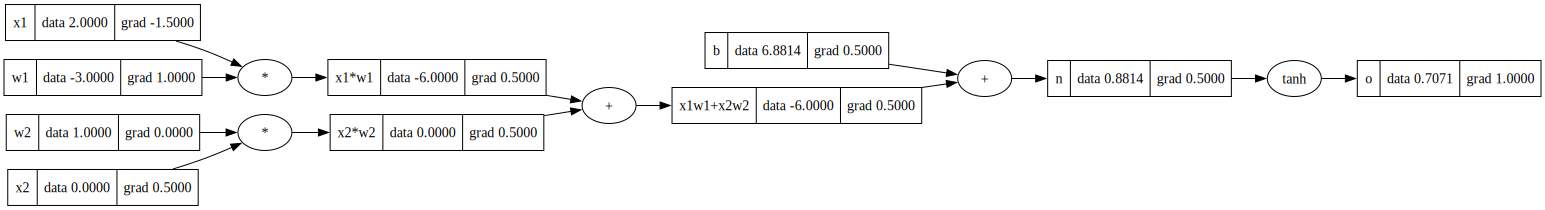

In [87]:
# manual grad
out.grad = 1.0
n.grad = 0.5        # dout/dn = 1 - out**2
x1w1x2w2.grad = 0.5 # dout/dx1w1x2w2 = dout/dn *dn/dx1w1x2w2 = 0.5 * 1
b.grad = 0.5        # dout/db = dout/dn *dn/db = 0.5 * 1    
x1w1.grad = 0.5     # dout/dx1w1 = dout/dx1w1x2w2 * dx1w1x2w2/dx1w1 = 0.5 * 1 
x2w2.grad = 0.5     # dout/dx2w2 = dout/dx1w1x2w2 * dx1w1x2w2/dx2w2 = 0.5 * 1
x2.grad = w2.data * x2w2.grad   
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad 
draw_dot(out)

In [86]:
1 - out.data**2

0.4999999999999999

In [141]:
# now we will apply a graph using neuron architecture and automitc grads

#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
out = n.tanh(); out.label = 'o'


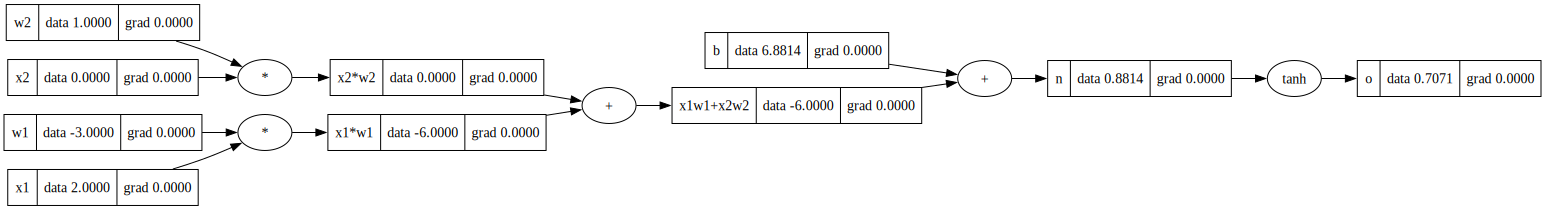

In [142]:
draw_dot(out)

In [105]:
out.grad = 1.0
out._backward()

In [106]:
n._backward()

In [111]:
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [126]:
# Topoligical order of our graph (reading from left to right)
topo_label = []
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo_label.append({v.label,v.data})
        topo.append(v)
build_topo(out)
topo_label
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [127]:
out.grad= 1.0
for node in reversed(topo):
    node._backward()

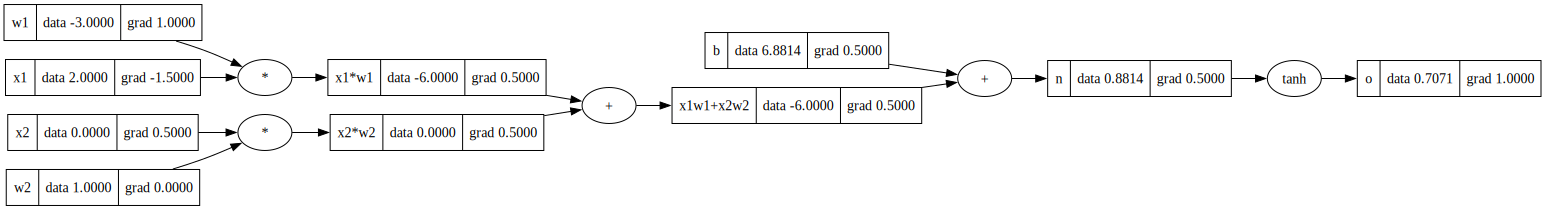

In [128]:
draw_dot(out)

In [143]:
out.backward()

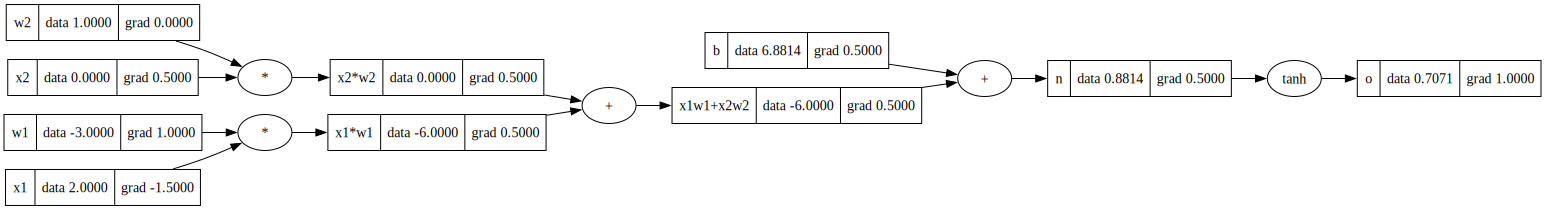

In [144]:
draw_dot(out)

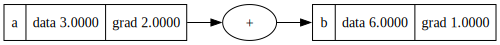

In [148]:
a = Value(3.0,label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)